## Setup

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import datetime

import functools
import IPython
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


import glucose_ts

# plot layouts
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 3.5})
sns.color_palette("dark")

plt.subplots_adjust(wspace=1.5)
DATA_DIR = os.path.join(os.path.dirname(os.path.dirname(glucose_ts.__file__)), 'data')


<Figure size 432x288 with 0 Axes>

## Load and Normalize the data


In [2]:
glucose_series = sorted(
    [
        glucose_ts.data.read_glucose_ts(os.path.join(DATA_DIR, file))
        for file in os.listdir(DATA_DIR)
        if file.startswith('Data')
    ] + [
        glucose_ts.data.read_glucose_ts(os.path.join(DATA_DIR, 'batch_samples', file))
        for file in os.listdir(
            os.path.join(
                DATA_DIR,
                'batch_samples'
            )
        )
    ] + [
        glucose_ts.data.read_glucose_ts(os.path.join(DATA_DIR, 'calibration', file))
        for file in os.listdir(
            os.path.join(
                DATA_DIR,
                'calibration'
            )
        )
    ] + [
        glucose_ts.data.read_glucose_ts(os.path.join(DATA_DIR, 'standards_warm', file))
        for file in os.listdir(
            os.path.join(
                DATA_DIR,
                'standards_warm'
            )
        )
    ] + [
        glucose_ts.data.read_glucose_ts(os.path.join(DATA_DIR, 'warm_standards_hamilton', file))
        for file in os.listdir(
            os.path.join(
                DATA_DIR,
                'warm_standards_hamilton'
            )
        )
    ]
    ,
    key=lambda one: one.real_concentration
)


glucose_series_0_5g = [series for series in glucose_series if series.real_concentration == 0.5]
glucose_series_1_0g = [series for series in glucose_series if series.real_concentration == 1.]

selection = [series for series in glucose_series if series.real_concentration >= 0]

train_mean = np.mean(np.concatenate([one.voltages for one in selection]))
train_std = np.std(np.concatenate([one.voltages for one in selection]))

thinning_factor = 10

normed_series = np.array([
    ((series.voltages - train_mean) / train_std)
    for series in selection
])

normed_series.shape, set([one.real_concentration for one in selection])

((85, 1000),
 {0.0,
  0.05,
  0.1,
  0.2,
  0.3,
  0.4,
  0.5,
  0.75,
  1,
  1.001,
  1.25,
  1.5,
  2.0,
  2.5,
  5.0,
  5.001,
  5.002,
  7.5,
  10.0})

## tf.data.Dataset Windows

Pay attention when create the training validation split randomly. The validation set must not be empty.

In [3]:
import random

CUT_OFF = 10

validation_indices = random.sample(range(len(normed_series)), k=10)

pure_training = [
    series 
    for idx, series in enumerate(normed_series) 
    if not idx in validation_indices
]
pure_validation = [
    series 
    for idx, series in enumerate(normed_series)
    if idx in validation_indices
]

np.array(pure_training).shape, np.array(pure_validation).shape

((75, 1000), (10, 1000))

In [4]:
# do some thinning as we do not need a time series of 1000 points

CLUSTER_LENGTH = 10
CUT_OFF_IDX = 15

training = glucose_ts.data.tf_data_windows.sample_time_series_dataset(
    data=pure_training,
    batch_size=64,
    cluster_cut_off_idx=CUT_OFF_IDX,
    cluster_length=CLUSTER_LENGTH,
    all_combinations=True,
    shuffle_data=True,
)

validation = glucose_ts.data.tf_data_windows.sample_time_series_dataset(
    data=pure_validation,
    batch_size=32,
    cluster_cut_off_idx=CUT_OFF_IDX,
    cluster_length=CLUSTER_LENGTH,
    all_combinations=False,
    shuffle_data=False
)

# print('Training shape %s' % str(training.shape))
# print('Validation set shape %s' % str(validation.shape))

# train_dataset = glucose_ts.data.create_training_dataset(
#     data=pure_training,
#     minimal_input_length=5,
#     fixed_label_length=False,
#     batch_size=32,
#     random_moving_average_bound=0,
#     fixed_cut_off=10,
# )
# validation_dataset = glucose_ts.data.create_validation_dataset(
#     data=validation,
#     cut_off=CUT_OFF,
# )


Here we see that for the training set we pick a random point in time where we splits the time-series. For technical reasons the label sequence need to have a fixed length. 

In [5]:
[(one.shape, two.shape) for one, two in training.take(10)]

[(TensorShape([64, 15, 1]), TensorShape([64, 85, 1])),
 (TensorShape([64, 15, 1]), TensorShape([64, 85, 1])),
 (TensorShape([64, 15, 1]), TensorShape([64, 85, 1])),
 (TensorShape([64, 15, 1]), TensorShape([64, 85, 1])),
 (TensorShape([64, 15, 1]), TensorShape([64, 85, 1])),
 (TensorShape([64, 15, 1]), TensorShape([64, 85, 1])),
 (TensorShape([64, 15, 1]), TensorShape([64, 85, 1])),
 (TensorShape([64, 15, 1]), TensorShape([64, 85, 1])),
 (TensorShape([64, 15, 1]), TensorShape([64, 85, 1])),
 (TensorShape([64, 15, 1]), TensorShape([64, 85, 1]))]

# Training Loop

In [6]:

def compile_and_fit_random(
    model,
    training_set,
    validation_set,
    patience=2,
    epochs=20,
    lr=1e-3,
    steps_per_epoch=20,
):

    model.compile(
        loss=glucose_ts.models.cost_functions.get_masked_loss_function(
            loss_type=tf.losses.MeanSquaredError,
        ),
        optimizer=tf.optimizers.Adam(learning_rate=lr),
        metrics=[]
    )

    history = model.fit(
        training_set,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=validation_set,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=patience,
                mode='min',
                restore_best_weights=True
            )]
    )
    model.build([None, None, 1])
    return history, model

# Model Evaluation

I splitted the regulation between the lstm and the dense layers. I did not try dropout so far. It is just a small change though.

In [11]:
len(list(training.unbatch().take(1000)))

1000

Epoch 1/200
500/500 [==============================] - 32s 40ms/step - loss: 0.4988 - val_loss: 0.5034
Epoch 2/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1788 - val_loss: 0.4115
Epoch 3/200
500/500 [==============================] - 18s 36ms/step - loss: 0.1481 - val_loss: 0.7578
Epoch 4/200
500/500 [==============================] - 18s 36ms/step - loss: 0.1359 - val_loss: 0.6018
Epoch 5/200
500/500 [==============================] - 18s 35ms/step - loss: 0.1275 - val_loss: 0.4501
Epoch 6/200
500/500 [==============================] - 20s 41ms/step - loss: 0.1231 - val_loss: 0.3045
Epoch 7/200
500/500 [==============================] - 18s 36ms/step - loss: 0.1164 - val_loss: 0.3149
Epoch 8/200
500/500 [==============================] - 17s 35ms/step - loss: 0.1081 - val_loss: 0.2670
Epoch 9/200
500/500 [==============================] - 18s 35ms/step - loss: 0.0964 - val_loss: 0.1715
Epoch 10/200
500/500 [==============================] - 18s 36ms/step - l

Epoch 80/200
500/500 [==============================] - 18s 35ms/step - loss: 0.0328 - val_loss: 0.0301
Epoch 81/200
500/500 [==============================] - 18s 35ms/step - loss: 0.0324 - val_loss: 0.0216
Epoch 82/200
500/500 [==============================] - 18s 36ms/step - loss: 0.0314 - val_loss: 0.0237
Epoch 83/200
500/500 [==============================] - 18s 35ms/step - loss: 0.0329 - val_loss: 0.0319
Epoch 84/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0342 - val_loss: 0.0197
Epoch 85/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0333 - val_loss: 0.0263
Epoch 86/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0318 - val_loss: 0.0217
Epoch 87/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0332 - val_loss: 0.0271
Epoch 88/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0324 - val_loss: 0.0174
Epoch 89/200
500/500 [==============================] - 17s 34ms

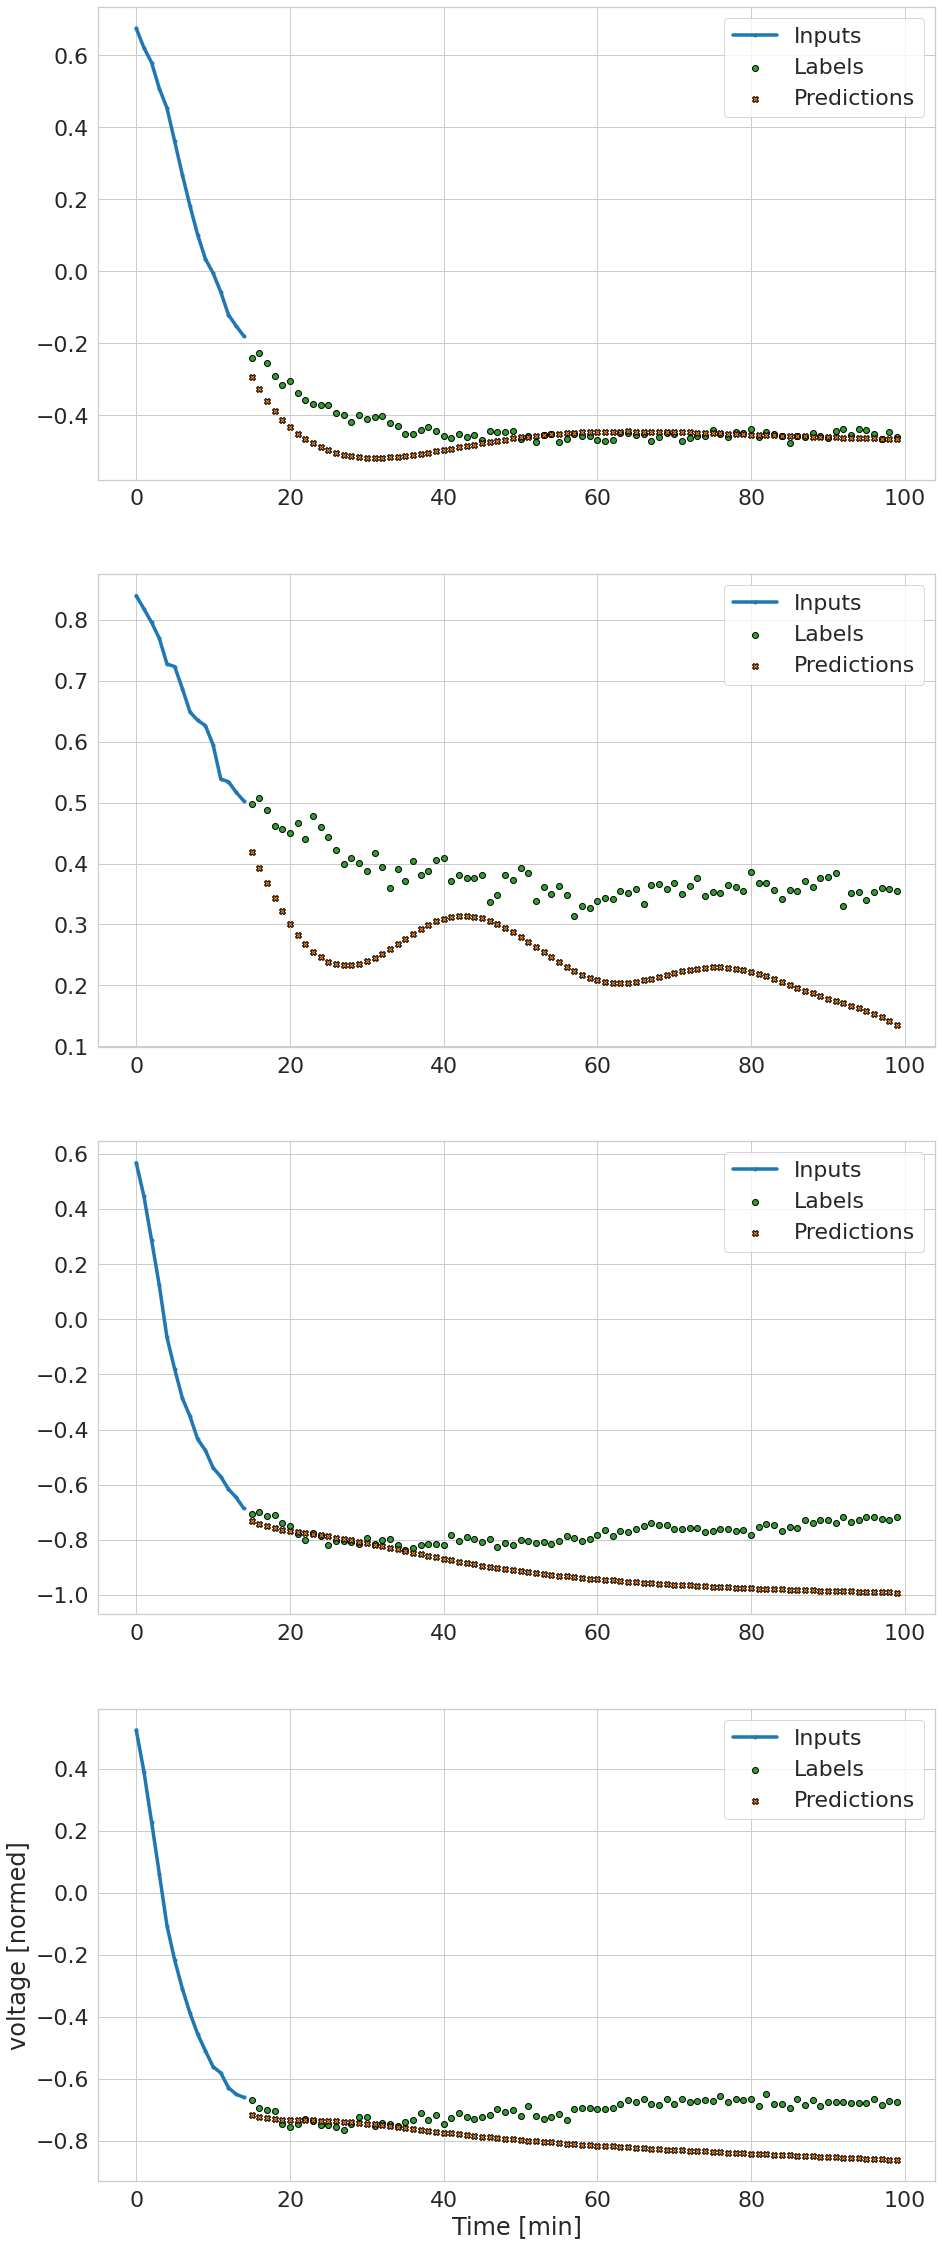

In [9]:
val_performance = {}

# Good setup

model = glucose_ts.models.VariableLSTM(
    units=18,
    total_length=100,
    label_length=100 - CUT_OFF_IDX,
    lstm_regularization=2e-8,
    dense_regularization=1e-8,
    norm_mean=0.,
    norm_std=1.,
    lstm_dropout=0.0,
    dense_dropout=0.0,
    dense_layer_sizes=(10, 5), 
)

with tf.device("GPU:0"):

    history, model = compile_and_fit_random(
        model,
        training_set=training.shuffle(100).prefetch(tf.data.AUTOTUNE),
        validation_set=validation,
        patience=20,
        epochs=200,
        lr=1e-4,
        steps_per_epoch=500,
    )

val_performance['AR LSTM'] = model.evaluate(validation)
model.summary()
glucose_ts.data.plot(validation.shuffle(100).take(1), model)

In [9]:
import itertools

val_performance = {}

def train_lstm(lstm_reg, dense_reg, units):
    
    print('lstm_reg: %.2E\n dense_reg: %.2E\n units: %s' % (lstm_reg, dense_reg, units))
    model = glucose_ts.models.VariableLSTM(
        units=18,
        total_length=100,
        label_length=100 - CUT_OFF_IDX,
        lstm_regularization=2e-8,
        dense_regularization=1e-8,
        norm_mean=0.,
        norm_std=1.,
        lstm_dropout=0.0,
        dense_dropout=0.0,
        dense_layer_sizes=(10, 5), 
    )

    with tf.device("GPU:0"):

        history, model = compile_and_fit_random(
            model,
            training_set=training.shuffle(100).prefetch(tf.data.AUTOTUNE),
            validation_set=validation,
            patience=20,
            epochs=200,
            lr=1e-4,
            steps_per_epoch=500,
        )

    val_performance['AR LSTM'] = model.evaluate(validation)
    model.summary()
    return model, history
# glucose_ts.data.plot(validation.shuffle(100).take(1), model)


cv_results = dict()
dropout_values = [0.005, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32]
reg_values = np.logspace(-8, -4, 10)
combinations = list(itertools.product([5e-10, 1e-9, 2e-9, 5e-9], [5e-9, 1e8], [14, 16, 18, 20, 22, 24]))

print('number of combinations is %s' % len(combinations))

with tf.device("GPU:0"):

    for parameter in (combinations)[25:]:
#         print('Number %s of %s' % (idx + 1, len(combinations)))
        cv_results[parameter] = train_lstm(*parameter)

number of combinations is 48
lstm_reg: 2.00E-09
 dense_reg: 5.00E-09
 units: 16
Epoch 1/200
500/500 [==============================] - 30s 35ms/step - loss: 0.4294 - val_loss: 0.4257
Epoch 2/200
500/500 [==============================] - 17s 34ms/step - loss: 0.2196 - val_loss: 0.2290
Epoch 3/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1247 - val_loss: 0.2644
Epoch 4/200
500/500 [==============================] - 17s 35ms/step - loss: 0.1076 - val_loss: 0.2495
Epoch 5/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1004 - val_loss: 0.2420
Epoch 6/200
500/500 [==============================] - 17s 35ms/step - loss: 0.0918 - val_loss: 0.2319
Epoch 7/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0841 - val_loss: 0.2187
Epoch 8/200
500/500 [==============================] - 17s 35ms/step - loss: 0.0780 - val_loss: 0.2070
Epoch 9/200
500/500 [==============================] - 17s 35ms/step - loss: 0.0732 - val_loss: 

500/500 [==============================] - 18s 36ms/step - loss: 0.0432 - val_loss: 0.0584
Epoch 80/200
500/500 [==============================] - 18s 35ms/step - loss: 0.0456 - val_loss: 0.0736
Epoch 81/200
500/500 [==============================] - 18s 35ms/step - loss: 0.0423 - val_loss: 0.0502
Epoch 82/200
500/500 [==============================] - 18s 35ms/step - loss: 0.0490 - val_loss: 0.0509
Epoch 83/200
500/500 [==============================] - 18s 35ms/step - loss: 0.0433 - val_loss: 0.0521
Epoch 84/200
500/500 [==============================] - 18s 36ms/step - loss: 0.0433 - val_loss: 0.0442
Epoch 85/200
500/500 [==============================] - 18s 35ms/step - loss: 0.0538 - val_loss: 0.0642
Epoch 86/200
500/500 [==============================] - 18s 35ms/step - loss: 0.0393 - val_loss: 0.0485
Epoch 87/200
500/500 [==============================] - 17s 35ms/step - loss: 0.0410 - val_loss: 0.0558
Epoch 88/200
500/500 [==============================] - 17s 35ms/step - loss:

500/500 [==============================] - 17s 34ms/step - loss: 0.0521 - val_loss: 0.1059
Epoch 69/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0509 - val_loss: 0.1072
Epoch 70/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0497 - val_loss: 0.0712
Epoch 71/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0797 - val_loss: 0.1006
Epoch 72/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0641 - val_loss: 0.0866
Epoch 73/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1650 - val_loss: 0.1226
Epoch 74/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0892 - val_loss: 0.1149
Epoch 75/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0470 - val_loss: 0.0892
Epoch 76/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0486 - val_loss: 0.0849
Epoch 77/200
500/500 [==============================] - 17s 34ms/step - loss:

Epoch 96/200
500/500 [==============================] - 22s 44ms/step - loss: 0.0357 - val_loss: 0.0265
Epoch 97/200
500/500 [==============================] - 23s 46ms/step - loss: 0.0295 - val_loss: 0.0310
Epoch 98/200
500/500 [==============================] - 22s 44ms/step - loss: 0.0293 - val_loss: 0.0231
Epoch 99/200
500/500 [==============================] - 23s 45ms/step - loss: 0.0305 - val_loss: 0.0225
Epoch 100/200
500/500 [==============================] - 24s 47ms/step - loss: 0.0302 - val_loss: 0.0253
Epoch 101/200
500/500 [==============================] - 21s 43ms/step - loss: 0.0393 - val_loss: 0.0237
Epoch 102/200
500/500 [==============================] - 22s 45ms/step - loss: 0.0299 - val_loss: 0.0199
Epoch 103/200
500/500 [==============================] - 25s 50ms/step - loss: 0.0283 - val_loss: 0.0206
Epoch 104/200
500/500 [==============================] - 21s 42ms/step - loss: 0.0319 - val_loss: 0.0895
Epoch 105/200
500/500 [==============================] - 24

500/500 [==============================] - 40s 45ms/step - loss: 0.5160 - val_loss: 0.2628
Epoch 2/200
500/500 [==============================] - 22s 45ms/step - loss: 0.1459 - val_loss: 0.2251
Epoch 3/200
500/500 [==============================] - 27s 53ms/step - loss: 0.1197 - val_loss: 0.2310
Epoch 4/200
500/500 [==============================] - 22s 43ms/step - loss: 0.1124 - val_loss: 0.2323
Epoch 5/200
500/500 [==============================] - 23s 47ms/step - loss: 0.1071 - val_loss: 0.2323
Epoch 6/200
500/500 [==============================] - 23s 45ms/step - loss: 0.1025 - val_loss: 0.2244
Epoch 7/200
500/500 [==============================] - 22s 44ms/step - loss: 0.0965 - val_loss: 0.2182
Epoch 8/200
500/500 [==============================] - 22s 44ms/step - loss: 0.0894 - val_loss: 0.2112
Epoch 9/200
500/500 [==============================] - 22s 44ms/step - loss: 0.0822 - val_loss: 0.2005
Epoch 10/200
500/500 [==============================] - 22s 44ms/step - loss: 0.0747 

Epoch 80/200
500/500 [==============================] - 18s 36ms/step - loss: 0.0426 - val_loss: 0.0514
Epoch 81/200
500/500 [==============================] - 18s 36ms/step - loss: 0.0417 - val_loss: 0.0446
Epoch 82/200
500/500 [==============================] - 18s 36ms/step - loss: 0.0361 - val_loss: 0.0475
Epoch 83/200
500/500 [==============================] - 18s 37ms/step - loss: 0.0666 - val_loss: 0.0532
Epoch 84/200
500/500 [==============================] - 19s 38ms/step - loss: 0.0368 - val_loss: 0.0418
Epoch 85/200
4/4 [==============================] - 0s 16ms/step - loss: 0.0391
Model: "variable_lstm_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_cell_5 (LSTMCell)       multiple                  1440      
_________________________________________________________________
rnn_5 (RNN)                  multiple                  1440      
_____________________________________________

500/500 [==============================] - 17s 35ms/step - loss: 0.0323 - val_loss: 0.0352
Epoch 144/200
500/500 [==============================] - 19s 38ms/step - loss: 0.0299 - val_loss: 0.0327
Epoch 145/200
500/500 [==============================] - 17s 35ms/step - loss: 0.0318 - val_loss: 0.0232
Epoch 146/200
500/500 [==============================] - 17s 35ms/step - loss: 0.0301 - val_loss: 0.0293
Epoch 147/200
500/500 [==============================] - 18s 36ms/step - loss: 0.0331 - val_loss: 0.0361
Epoch 148/200
500/500 [==============================] - 19s 38ms/step - loss: 0.0314 - val_loss: 0.0300
Epoch 149/200
500/500 [==============================] - 19s 39ms/step - loss: 0.0301 - val_loss: 0.0328
Epoch 150/200
500/500 [==============================] - 19s 37ms/step - loss: 0.0309 - val_loss: 0.0305
Epoch 151/200
500/500 [==============================] - 17s 35ms/step - loss: 0.0287 - val_loss: 0.0243
Epoch 152/200
500/500 [==============================] - 18s 35ms/ste

500/500 [==============================] - 19s 38ms/step - loss: 0.0554 - val_loss: 0.1619
Epoch 14/200
500/500 [==============================] - 20s 40ms/step - loss: 0.0550 - val_loss: 0.1668
Epoch 15/200
500/500 [==============================] - 19s 38ms/step - loss: 0.0547 - val_loss: 0.1574
Epoch 16/200
500/500 [==============================] - 19s 38ms/step - loss: 0.0536 - val_loss: 0.1532
Epoch 17/200
500/500 [==============================] - 19s 39ms/step - loss: 0.0534 - val_loss: 0.1574
Epoch 18/200
500/500 [==============================] - 19s 39ms/step - loss: 0.0530 - val_loss: 0.1614
Epoch 19/200
500/500 [==============================] - 19s 39ms/step - loss: 0.0525 - val_loss: 0.1476
Epoch 20/200
500/500 [==============================] - 19s 38ms/step - loss: 0.0520 - val_loss: 0.1462
Epoch 21/200
500/500 [==============================] - 19s 38ms/step - loss: 0.0517 - val_loss: 0.1437
Epoch 22/200
500/500 [==============================] - 19s 38ms/step - loss:

Epoch 92/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0335 - val_loss: 0.0280
Epoch 93/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0312 - val_loss: 0.0278
Epoch 94/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0336 - val_loss: 0.0363
Epoch 95/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0354 - val_loss: 0.0339
Epoch 96/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0324 - val_loss: 0.0281
Epoch 97/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1701 - val_loss: 0.1488
Epoch 98/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0437 - val_loss: 0.0350
Epoch 99/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0325 - val_loss: 0.0314
Epoch 100/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1259 - val_loss: 0.1513
Epoch 101/200
4/4 [==============================] - 0s 16ms/st

500/500 [==============================] - 17s 34ms/step - loss: 0.1102 - val_loss: 0.2203
Epoch 5/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1019 - val_loss: 0.2152
Epoch 6/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0949 - val_loss: 0.2113
Epoch 7/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0889 - val_loss: 0.2101
Epoch 8/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0797 - val_loss: 0.2144
Epoch 9/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0744 - val_loss: 0.2065
Epoch 10/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0730 - val_loss: 0.2063
Epoch 11/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0712 - val_loss: 0.2017
Epoch 12/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0709 - val_loss: 0.2020
Epoch 13/200
500/500 [==============================] - 17s 34ms/step - loss: 0.06

Epoch 83/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0306 - val_loss: 0.0271
Epoch 84/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0299 - val_loss: 0.0257
Epoch 85/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0319 - val_loss: 0.0262
Epoch 86/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0296 - val_loss: 0.0377
Epoch 87/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0305 - val_loss: 0.0255
Epoch 88/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0324 - val_loss: 0.0324
Epoch 89/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0306 - val_loss: 0.0297
Epoch 90/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0282 - val_loss: 0.0287
Epoch 91/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0326 - val_loss: 0.0269
Epoch 92/200
500/500 [==============================] - 17s 34ms

Epoch 101/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0343 - val_loss: 0.0615
Epoch 102/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0481 - val_loss: 0.0497
Epoch 103/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0358 - val_loss: 0.0549
Epoch 104/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0333 - val_loss: 0.0600
Epoch 105/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0341 - val_loss: 0.0427
Epoch 106/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0372 - val_loss: 0.0530
Epoch 107/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0407 - val_loss: 0.0592
Epoch 108/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0389 - val_loss: 0.0416
Epoch 109/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0619 - val_loss: 0.0462
Epoch 110/200
500/500 [==============================] 

500/500 [==============================] - 30s 35ms/step - loss: 0.6805 - val_loss: 0.2603
Epoch 2/200
500/500 [==============================] - 17s 34ms/step - loss: 0.3883 - val_loss: 0.2183
Epoch 3/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1895 - val_loss: 0.2045
Epoch 4/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1642 - val_loss: 0.2108
Epoch 5/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1572 - val_loss: 0.2191
Epoch 6/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1420 - val_loss: 0.2415
Epoch 7/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1337 - val_loss: 0.2369
Epoch 8/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1168 - val_loss: 0.2252
Epoch 9/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0885 - val_loss: 0.2069
Epoch 10/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0829 

Epoch 80/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0508 - val_loss: 0.0526
Epoch 81/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0342 - val_loss: 0.0447
Epoch 82/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0384 - val_loss: 0.0386
Epoch 83/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0593 - val_loss: 0.0349
Epoch 84/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0364 - val_loss: 0.0314
Epoch 85/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0407 - val_loss: 0.0326
Epoch 86/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0280
Model: "variable_lstm_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_cell_12 (LSTMCell)      multiple                  1440      
_________________________________________________________________
rnn_12

500/500 [==============================] - 17s 34ms/step - loss: 0.0602 - val_loss: 0.1827
Epoch 24/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0591 - val_loss: 0.1796
Epoch 25/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0586 - val_loss: 0.1813
Epoch 26/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0577 - val_loss: 0.1808
Epoch 27/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0567 - val_loss: 0.1799
Epoch 28/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0563 - val_loss: 0.1836
Epoch 29/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0557 - val_loss: 0.1846
Epoch 30/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0547 - val_loss: 0.1743
Epoch 31/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0544 - val_loss: 0.1754
Epoch 32/200
500/500 [==============================] - 17s 34ms/step - loss:

500/500 [==============================] - 17s 34ms/step - loss: 0.0395 - val_loss: 0.1276
Epoch 35/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0380 - val_loss: 0.1351
Epoch 36/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0380 - val_loss: 0.0855
Epoch 37/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0365 - val_loss: 0.0823
Epoch 38/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0352 - val_loss: 0.0967
Epoch 39/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0351 - val_loss: 0.0714
Epoch 40/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0343 - val_loss: 0.0716
Epoch 41/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0336 - val_loss: 0.0555
Epoch 42/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0334 - val_loss: 0.0559
Epoch 43/200
500/500 [==============================] - 17s 34ms/step - loss:

Epoch 113/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0237 - val_loss: 0.0248
Epoch 114/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0229 - val_loss: 0.0332
Epoch 115/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0233 - val_loss: 0.0237
Epoch 116/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0258 - val_loss: 0.0243
Epoch 117/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0217 - val_loss: 0.0243
Epoch 118/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0225 - val_loss: 0.0207
Epoch 119/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0226 - val_loss: 0.0259
Epoch 120/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0231 - val_loss: 0.0238
Epoch 121/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0232 - val_loss: 0.0210
Epoch 122/200
500/500 [==============================] 

500/500 [==============================] - 17s 34ms/step - loss: 0.0707 - val_loss: 0.0777
Epoch 31/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0422 - val_loss: 0.0667
Epoch 32/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0624 - val_loss: 0.1062
Epoch 33/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1348 - val_loss: 0.4086
Epoch 34/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0535 - val_loss: 0.0754
Epoch 35/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0436 - val_loss: 0.0568
Epoch 36/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0459 - val_loss: 0.0666
Epoch 37/200
500/500 [==============================] - 17s 34ms/step - loss: 0.1173 - val_loss: 0.0721
Epoch 38/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0422 - val_loss: 0.0827
Epoch 39/200
500/500 [==============================] - 17s 34ms/step - loss:

500/500 [==============================] - 17s 34ms/step - loss: 0.0509 - val_loss: 0.0793
Epoch 94/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0337 - val_loss: 0.0228
Epoch 95/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0333 - val_loss: 0.0276
Epoch 96/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0320 - val_loss: 0.0240
Epoch 97/200
500/500 [==============================] - 17s 34ms/step - loss: 0.2160 - val_loss: 0.1530
Epoch 98/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0611 - val_loss: 0.0888
Epoch 99/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0476 - val_loss: 0.0460
Epoch 100/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0411 - val_loss: 0.0364
Epoch 101/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0343 - val_loss: 0.0258
Epoch 102/200
500/500 [==============================] - 17s 34ms/step - lo

500/500 [==============================] - 17s 34ms/step - loss: 0.0286 - val_loss: 0.0221
Epoch 120/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0272 - val_loss: 0.0252
Epoch 121/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0283 - val_loss: 0.0235
Epoch 122/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0285 - val_loss: 0.0257
Epoch 123/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0273 - val_loss: 0.0274
Epoch 124/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0284 - val_loss: 0.0272
Epoch 125/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0277 - val_loss: 0.0281
Epoch 126/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0279 - val_loss: 0.0296
Epoch 127/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0287 - val_loss: 0.0258
Epoch 128/200
500/500 [==============================] - 17s 34ms/ste

500/500 [==============================] - 17s 34ms/step - loss: 0.0610 - val_loss: 0.1768
Epoch 21/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0610 - val_loss: 0.1741
Epoch 22/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0607 - val_loss: 0.1781
Epoch 23/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0603 - val_loss: 0.1805
Epoch 24/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0601 - val_loss: 0.1719
Epoch 25/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0597 - val_loss: 0.1692
Epoch 26/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0594 - val_loss: 0.1727
Epoch 27/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0596 - val_loss: 0.1815
Epoch 28/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0592 - val_loss: 0.1721
Epoch 29/200
500/500 [==============================] - 17s 34ms/step - loss:

Epoch 99/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0338 - val_loss: 0.0727
Epoch 100/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0350 - val_loss: 0.0501
Epoch 101/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0335 - val_loss: 0.0515
Epoch 102/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0334 - val_loss: 0.0486
Epoch 103/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0342 - val_loss: 0.0485
Epoch 104/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0331 - val_loss: 0.0474
Epoch 105/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0367 - val_loss: 0.0579
Epoch 106/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0364 - val_loss: 0.0572
Epoch 107/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0329 - val_loss: 0.0562
Epoch 108/200
500/500 [==============================] -

Epoch 8/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0770 - val_loss: 0.1944
Epoch 9/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0747 - val_loss: 0.1932
Epoch 10/200
500/500 [==============================] - 18s 36ms/step - loss: 0.0733 - val_loss: 0.1890
Epoch 11/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0709 - val_loss: 0.1879
Epoch 12/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0701 - val_loss: 0.1781
Epoch 13/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0682 - val_loss: 0.1819
Epoch 14/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0667 - val_loss: 0.1847
Epoch 15/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0654 - val_loss: 0.1769
Epoch 16/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0640 - val_loss: 0.1805
Epoch 17/200
500/500 [==============================] - 17s 34ms/s

500/500 [==============================] - 17s 34ms/step - loss: 0.0570 - val_loss: 0.1899
Epoch 32/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0565 - val_loss: 0.1801
Epoch 33/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0563 - val_loss: 0.1804
Epoch 34/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0558 - val_loss: 0.1775
Epoch 35/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0563 - val_loss: 0.1778
Epoch 36/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0556 - val_loss: 0.1828
Epoch 37/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0562 - val_loss: 0.1750
Epoch 38/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0552 - val_loss: 0.1859
Epoch 39/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0544 - val_loss: 0.1709
Epoch 40/200
500/500 [==============================] - 17s 34ms/step - loss:

Epoch 110/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0519 - val_loss: 0.0959
Epoch 111/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0439 - val_loss: 0.0542
Epoch 112/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0432 - val_loss: 0.0600
Epoch 113/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0440 - val_loss: 0.0650
Epoch 114/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0420 - val_loss: 0.0592
Epoch 115/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0435 - val_loss: 0.0735
Epoch 116/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0431 - val_loss: 0.0552
Epoch 117/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0446 - val_loss: 0.0640
Epoch 118/200
500/500 [==============================] - 17s 34ms/step - loss: 0.0425 - val_loss: 0.1064
Epoch 119/200
500/500 [==============================] 

In [27]:
model.evaluate(validation)

7/7 [==============================] - 0s 14ms/step - loss: 0.0907


0.09069262444972992

Epoch 1/80
500/500 [==============================] - 32s 37ms/step - loss: 0.5437 - val_loss: 0.3717
Epoch 2/80
500/500 [==============================] - 17s 34ms/step - loss: 0.2627 - val_loss: 0.1620
Epoch 3/80
500/500 [==============================] - 18s 36ms/step - loss: 0.1516 - val_loss: 0.2072
Epoch 4/80
500/500 [==============================] - 17s 35ms/step - loss: 0.1445 - val_loss: 0.1742
Epoch 5/80
500/500 [==============================] - 17s 34ms/step - loss: 0.1387 - val_loss: 0.1744
Epoch 6/80
500/500 [==============================] - 17s 34ms/step - loss: 0.1376 - val_loss: 0.1782
Epoch 7/80
500/500 [==============================] - 17s 34ms/step - loss: 0.1358 - val_loss: 0.1418
Epoch 8/80
500/500 [==============================] - 17s 34ms/step - loss: 0.1345 - val_loss: 0.1560
Epoch 9/80
500/500 [==============================] - 17s 34ms/step - loss: 0.1346 - val_loss: 0.1883
Epoch 10/80
500/500 [==============================] - 17s 34ms/step - loss: 0.132

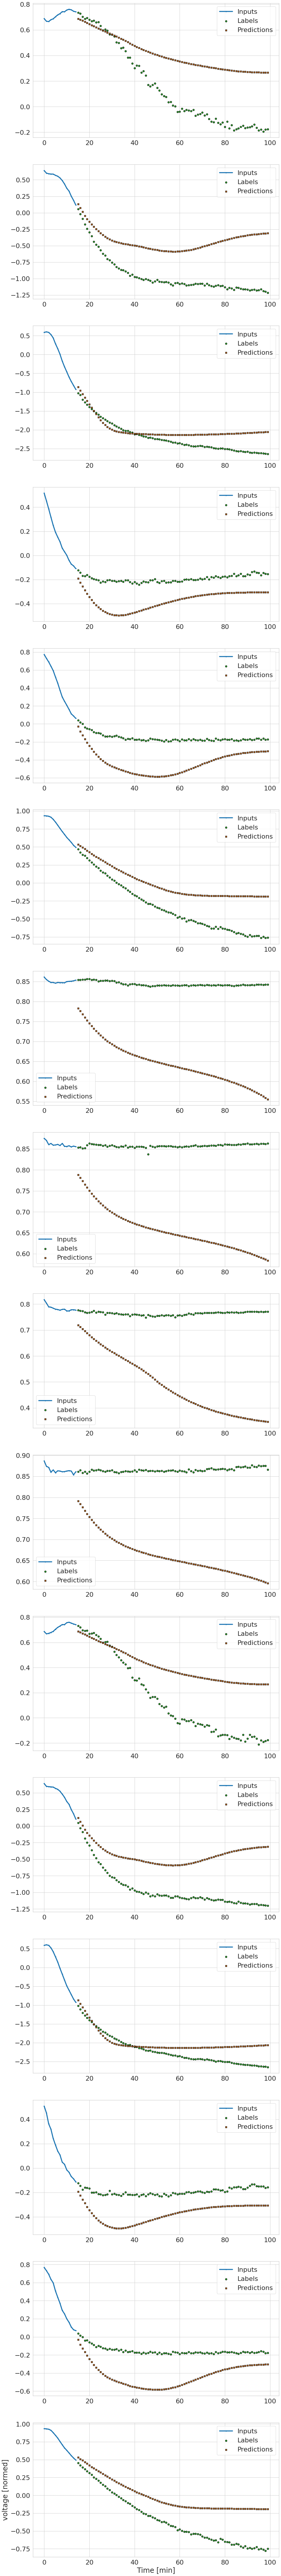

In [79]:
val_performance = {}

dropout_model = glucose_ts.models.VariableLSTM(
    units=20,
    total_length=100,
    label_length=100 - CUT_OFF_IDX,
    lstm_regularization=1e-8,
    dense_regularization=3e-4,
    norm_mean=0.,
    norm_std=1.,
    lstm_dropout=0.02,
    dense_dropout=0.0,
    dense_layer_sizes=(8, 4, ), 
)

with tf.device("CPU:0"):

    history, dropout_model = compile_and_fit_random(
        dropout_model,
        training_set=training.shuffle(100).prefetch(1000),
        validation_set=validation,
        patience=10,
        epochs=80,
        lr=1e-4,
        steps_per_epoch=500,
    )

val_performance['AR LSTM'] = dropout_model.evaluate(validation)
dropout_model.summary()
glucose_ts.data.plot(validation.shuffle(100).take(1), dropout_model)

In [10]:
model.evaluate(validation)

4/4 [==============================] - 0s 44ms/step - loss: 0.1214


0.12136317044496536

In [11]:
end_point = max(glucose_series[0].points_in_time)
points_in_time = np.linspace(0., end_point, 50)

len(points_in_time), int(CUT_OFF * LENGTH)

NameError: name 'LENGTH' is not defined

In [ ]:
train_mean, train_std, un_normalize(tf.constant([0., 0., 0.]), train_mean, train_std)

In [ ]:
LENGTH = 50

length = 5


fig, axises = plt.subplots(
    length,
    1,
    figsize=(15, 10 * length)
)

def un_normalize(data, mean, std):
    return tf.add(tf.multiply(data, tf.cast(std, dtype=data.dtype)), tf.cast(mean, dtype=data.dtype))


for ax, (inputs, labels) in zip(axises.flatten(), validation.unbatch().take(length)):
    predictions = model(inputs[tf.newaxis, :, :])
    
    voltage_inputs = un_normalize(inputs, train_mean, train_std)
    voltage_labels = un_normalize(labels, train_mean, train_std)
    voltage_predictions = un_normalize(predictions, train_mean, train_std)
    
    
    ax.set_ylabel('voltage [V]')
    ax.set_xlabel('time [min]')

    ax.plot(
        points_in_time[:int(CUT_OFF * LENGTH)],
        voltage_inputs,
        label='Inputs',
    )

    ax.plot(
        points_in_time[int(CUT_OFF * LENGTH):],
        voltage_labels,
        label='Labels',
    )
    ax.plot(
        points_in_time[int(CUT_OFF * LENGTH):],
        voltage_predictions[0, :, 0],
        label='Predictions',
    )
    
    ax.axvline(
        x=max(points_in_time) * CUT_OFF,
        label='cutoff',
        linestyle='--',
        color='crimson'
    )
    ax.legend()




In [ ]:
FINAL_THRESHOLD = 7.
final_voltage(tf.range(40))

In [ ]:
import math

FINAL_THRESHOLD = 7.
cut_off = math.ceil((FINAL_THRESHOLD / max(points_in_time) - CUT_OFF) * LENGTH)

def final_voltage(voltages):
    return tf.reduce_mean(voltages[cut_off:])
    
    
residuals = []

for inputs, labels in validation.unbatch():

    predictions = model(inputs[tf.newaxis, :, :])
    
    final_voltage_predictions = final_voltage(
        un_normalize(predictions, train_mean, train_std)[0, :, 0]
    )
    final_voltage_labels = final_voltage(
        un_normalize(labels, train_mean, train_std)[:, 0]
    )
    
    residuals.append(float(final_voltage_predictions - final_voltage_labels))
    
len(residuals)



In [ ]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(10, 10)
)



sns.histplot(residuals, kde=True, ax=ax)
ax.set_xlabel('predicted final voltage - final voltage', labelpad=20)
print(sum([one ** 2 for one in residuals]) / len(residuals))

In [ ]:
for ax, (inputs, labels) in zip(axises.flatten(), validation.unbatch().take(length)):
    predictions = model(inputs[tf.newaxis, :, :])
    
    voltage_inputs = un_normalize(inputs, train_mean, train_std)
    voltage_labels = un_normalize(labels, train_mean, train_std)
    voltage_predictions = un_normalize(predictions, train_mean, train_std)


In [ ]:
import collections

LSTM_Parameter = collections.namedtuple(
    'LSTM_Parameter',
    ['units', 
     'dropout',
     'lstm_reg', 'dense_reg',
     'learning_rate']
)

all_results_reg = []


for idx, params in enumerate(itertools.product(
    range(6, 16, 3),
    [0.],
    np.logspace(-7, -3, 3),
    np.logspace(-7, -3, 3),
    np.logspace(-3, -2, 3),
)):
    parameter = LSTM_Parameter(*params)
    
    print('number %s' % idx)
    print('units %s' % parameter.units)
    print('dropout %4.2f' % parameter.dropout)
    print('lstm reg %8.6f' % parameter.lstm_reg)
    print('dense reg %8.6f' % parameter.dense_reg)
    print('learning rate %8.6f' % parameter.learning_rate)
    
    
    results = glucose_ts.models.utils.cross_validation(
        dataset=normed_series,
        model=glucose_ts.models.VariableLSTM(
            units=parameter.units,
            total_length=50,
            label_length=40,
            lstm_regularization=parameter.lstm_reg,
            dense_regularization=parameter.dense_reg,
            lstm_dropout=parameter.dropout,
        ),
        num_folds=3,
        steps_per_epoch=500,
        epochs=30,
        patience=6,
        cut_off=.2,
        cluster_length=20,
        learning_rate=parameter.learning_rate,
    )
    print('results: %s' % results)
    all_results_reg.append((parameter, results))
    




In [ ]:
len(all_results_reg)

In [ ]:
all_units, all_dropout, all_lstm_reg, all_dense_reg, all_lrs = zip(*[one[0] for one in all_results_reg])
fold_1, fold_2, fold_3 = zip(*[one[1] for one in all_results_reg])

In [ ]:
hyper_tuning_reg = pd.DataFrame({
    'units': all_units,
    'dropout': all_dropout,
    'lstm_reg': all_lstm_reg,
    'dense_reg': all_dense_reg,
    'learning_rate': all_lrs,
    'fold_1': fold_1,
    'fold_2': fold_2,
    'fold_3': fold_3,
})
hyper_tuning_reg

In [ ]:
hyper_tuning = pd.DataFrame({
    'units': all_units,
    'dropout': all_dropout,
    'learning_rate': all_lrs,
    'fold_1': fold_1,
    'fold_2': fold_2,
    'fold_3': fold_3,
})
hyper_tuning_reg['avg_result'] = (hyper_tuning_reg['fold_1'] + hyper_tuning_reg['fold_2'] + hyper_tuning_reg['fold_3']) / 3
hyper_tuning_reg.sort_values(by=['avg_result'])

In [ ]:
hyper_tuning['avg_result'] = (hyper_tuning['fold_1'] + hyper_tuning['fold_2'] + hyper_tuning['fold_3']) / 3
hyper_tuning.to_csv('hyper_tuning_dropout.csv')

# Christoph's 2 cent

## Observations

The model learns one observation that fits all use-cases. If you look at the two plots the prediction curves are identical.

There is no smooth transition from the inputs to the predictions. You can see it with the two inputs. For the second one there is quite a smooth transition from the inputs to the predictions. For the first one there is a little jump from the input to the predictions.

## Conclusions

It does not really differentiate between the two validation examples.

The model does not learn the next prediction from the concrete last steps.


## Next steps

* Try dropout
* Make a systematic grid search
* try more data augmentation for generating more data
* GAN?
* Wait for more data
* physics informed network that learns the five parameters of the ODE
* try a smoothness regularization term?
* try a convolutional network


In [ ]:
os.path.join(os.path.dirname(os.path.dirname(glucose_ts.__file__)), 'presenations', 'images', 'time_series_dataset.png')

In [ ]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(15, 10)
)


for series in glucose_series:   
    
    ax.set_ylabel('voltage [V]')
    ax.set_xlabel('time [min]')

    ax.plot(
        series.points_in_time,
        series.voltages,
    )
fig.savefig(os.path.join(os.path.dirname(os.path.dirname(glucose_ts.__file__)), 'presentations', 'images', 'time_series_dataset.png'), transparent=True)